<h1>IBM Data Science Capstone: The Battle of Neighbourhoods</h1>

In [1]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import json
from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans

import folium

from geopy.geocoders import Nominatim
from selenium import webdriver

<h3>Obtaining boroughs of London</h3>

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
resp = requests.get(url)
london_soup = BeautifulSoup(resp.text, 'html.parser')
london_table = london_soup.find('table', attrs={'class':'wikitable sortable'})

In [3]:
l = []
table_rows = london_table.find_all('tr')
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
postcode=pd.DataFrame(l, columns=['Location', 'London borough', 'Post town', 'Postcode district', 'Dial code', 'OS grid ref'])
postcode.drop([0], inplace=True)
c_london = postcode[postcode['Post town']=='LONDON']
c_london['OS grid ref']=c_london['OS grid ref'].str.replace(r'\n','')

C:\Users\tanmf\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<h3>Getting Latitude and Longitudes of postcodes</h3>
<p><h4><b>The Data:</b> Post codes were obtained from wikipedia. Longitude, Latitude and Average Income was obtained from a csv file available on Office for National Statistics (ONS) 

In [4]:
info = pd.read_csv('London postcodes.csv')
info =info[info['In Use?']=='Yes']

<h5><p>Exact postcode district was missing in London postcodes.csv.
OS grid reference is a shared component of the 2 dataframes thus was used to merge instead.</p>
<p>London borough duplicates were dropped as it may postcodes that coincide with another district</p>
    <p>As Latitude and Longitude was missing for some boroughs, they were dropped</p>

In [5]:
c_london2= pd.merge(c_london, info[['Latitude', 'Longitude', 'Grid Ref', 'Average Income']], left_on='OS grid ref', right_on='Grid Ref', how='left')
c_london2.drop_duplicates('London borough', inplace=True)

In [6]:
c_london2.isnull().sum()

Location              0
London borough        0
Post town             0
Postcode district     0
Dial code             0
OS grid ref           0
Latitude             29
Longitude            29
Grid Ref             29
Average Income       29
dtype: int64

In [7]:
c_london2.dropna(inplace=True)
c_london2

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref,Latitude,Longitude,Grid Ref,Average Income
2,Aldgate,City[10],LONDON,EC3,020,TQ334813,51.515526,-0.078592,TQ334813,65400.0
9,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810,51.513601,-0.116964,TQ307810,59000.0
13,Anerley,Bromley[11],LONDON,SE20,020,TQ345695,51.408894,-0.066886,TQ345695,43100.0
15,Angel,Islington[8],LONDON,"EC1, N1",020,TQ345665,51.382106,-0.068576,TQ345665,59100.0
18,Balham,Wandsworth[13],LONDON,SW12,020,TQ285735,51.446384,-0.151563,TQ285735,71800.0
36,Bankside,Southwark[14],LONDON,SE1,020,TQ325795,51.499479,-0.092231,TQ325795,54700.0
42,Barbican,City[14],LONDON,EC1,020,TQ322818,51.519915,-0.095298,TQ322818,65400.0
47,Barnsbury,Islington[17],LONDON,N1,020,TQ305845,51.545015,-0.119203,TQ305845,42600.0
52,Bayswater,Westminster[19],LONDON,W2,020,TQ255805,51.510224,-0.192689,TQ255805,58500.0
55,Bedford Park,Ealing[21],LONDON,W4,020,TQ208793,51.500206,-0.261032,TQ208793,72900.0


In [8]:
address = 'London, UK'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of London is', latitude,',', longitude)

The geographical coordinate of London is 51.5073219 , -0.1276474


In [9]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, location in zip(c_london2['Latitude'], c_london2['Longitude'], c_london2['London borough'], c_london2['Location']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
map_london

<h3>Explore boroughs of London</h3>

In [10]:
CLIENT_ID = 'MLPPKTJYN1W2354A3QSXXOE4O2LD42ALPDIZ53O0X31BLK0Q' # your Foursquare ID
CLIENT_SECRET = 'I1RKNL1WOTRPCZ44K1S5YTSNS5RPS4RFSWD0ZXJ42HI1IS3Z' # your Foursquare Secret
VERSION = '20180604'
LIMIT=30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MLPPKTJYN1W2354A3QSXXOE4O2LD42ALPDIZ53O0X31BLK0Q
CLIENT_SECRET:I1RKNL1WOTRPCZ44K1S5YTSNS5RPS4RFSWD0ZXJ42HI1IS3Z


In [11]:
bloomsbury_loc = c_london2.loc[82, 'Location']
bloomsbury_lat= c_london2.loc[82, 'Latitude']
bloomsbury_long = c_london2.loc[82, 'Longitude']
print('Latitude and Longitude values of',bloomsbury_loc, 'are',bloomsbury_lat,', ',bloomsbury_long)

Latitude and Longitude values of Bloomsbury are 51.526833 ,  -0.119993


Top venues located in Bloomsbury within radius of 800 meters

In [12]:
radius=800
limit=100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    bloomsbury_lat, 
    bloomsbury_long, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=MLPPKTJYN1W2354A3QSXXOE4O2LD42ALPDIZ53O0X31BLK0Q&client_secret=I1RKNL1WOTRPCZ44K1S5YTSNS5RPS4RFSWD0ZXJ42HI1IS3Z&v=20180604&ll=51.526833,-0.119993&radius=800&limit=30'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eabe75f660a9f001bd5c441'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': "King's Cross",
  'headerFullLocation': "King's Cross, London",
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 138,
  'suggestedBounds': {'ne': {'lat': 51.53403300720001,
    'lng': -0.10844178816873717},
   'sw': {'lat': 51.5196329928, 'lng': -0.13154421183126283}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5200a560498ec1b0f59f7eb0',
       'name': 'Aux Pains de Papy',
       'location': {'address': '279 Grays Inn Rd',
        'lat': 51.52934,
        'lng': -0.12030311,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.52934,
  

Extract necessary information for each venue with a function and format into a dataframe

In [14]:
def venue_category(place):
    try:
        categories_list = place['categories']
    except:
        categories_list = place['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues)
nearby_venues.columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues=nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(venue_category, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Aux Pains de Papy,Bakery,51.529340,-0.120303
1,Patisserie Deux Amis,Coffee Shop,51.526798,-0.124189
2,St George's Gardens,Garden,51.525850,-0.121612
3,The Queen's Head,Pub,51.528343,-0.118558
4,Curzon Bloomsbury,Movie Theater,51.524120,-0.123002


In [16]:
nearby_venues.shape[0]

30

In [17]:
# Plot a map of the venues of Bloomsbury
map_bb = folium.Map(location=[bloomsbury_lat, bloomsbury_long], zoom_start=15)

for lat, lng, borough, location in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bb)  
map_bb

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
london_venues = getNearbyVenues(names=c_london2['Location'], latitudes=c_london2['Latitude'], longitudes=c_london2['Longitude'])

Aldgate
Aldwych
Anerley
Angel
Balham
Bankside
Barbican
Barnsbury
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Blackfriars
Blackwall
Bloomsbury
Bounds Green
Bow
Brent Cross
Brixton
Bromley (also Bromley-by-Bow)
Brompton
Brondesbury
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Chiswick
Clapham
Clerkenwell
Colliers Wood
Cricklewood
Custom House
Dalston
Dartford
Ealing
East Sheen
Edmonton
Farringdon
Fulham
Gipsy Hill
Grove Park
Horn Park
Kennington
King's Cross
Muswell Hill
Sydenham (also Lower Sydenham, Upper Sydenham)
Sydenham Hill
Temple
Tufnell Park


In [20]:
london_venues.groupby('Location').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Location,,,,,,
Aldgate,30,30,30,30,30,30
Aldwych,30,30,30,30,30,30
Anerley,6,6,6,6,6,6
Angel,13,13,13,13,13,13
Balham,30,30,30,30,30,30
Bankside,30,30,30,30,30,30
Barbican,30,30,30,30,30,30
Barnsbury,30,30,30,30,30,30
Bayswater,30,30,30,30,30,30


In [21]:
# encode each venue
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Location'] = london_venues['Location'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

,Location,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# function that sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
london_grouped = london_onehot.groupby('Location').mean().reset_index()
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = london_grouped['Location']

for ind in np.arange(london_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

location_venues_sorted[:10]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aldgate,Coffee Shop,Cocktail Bar,Salad Place,Pizza Place,Burger Joint
1,Aldwych,Theater,Hotel,Pub,Italian Restaurant,Park
2,Anerley,Train Station,Park,Pub,Gas Station,Hardware Store
3,Angel,Park,Grocery Store,Bakery,Tram Station,Café
4,Balham,Pub,Coffee Shop,Indian Restaurant,Bakery,Bar
5,Bankside,Pub,Argentinian Restaurant,Sandwich Place,Theater,Café
6,Barbican,Gym / Fitness Center,Coffee Shop,Indie Movie Theater,Art Gallery,Theater
7,Barnsbury,Rental Car Location,Café,Brewery,Theater,Grocery Store
8,Bayswater,Pub,Gym / Fitness Center,Portuguese Restaurant,Playground,Pizza Place
9,Bedford Park,Bakery,Café,Gastropub,Yoga Studio,Bus Stop


<h3>Clustering neighborhoods</h3>

Choosing most appropriate no of clusters

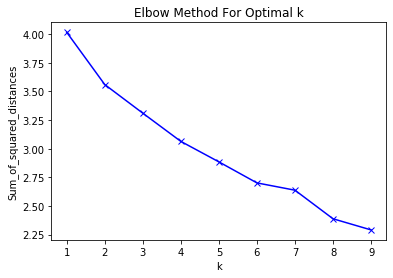

In [24]:
K = range(1,10)
london_grouped_cluster = london_grouped.drop('Location', 1)
sum_squared_distances = []
for k in K:
    
    #Train Model and Predict  
    kmeanmodel=KMeans(n_clusters = k).fit(london_grouped_cluster)
    kmeanmodel.fit(london_grouped_cluster)
    sum_squared_distances.append(kmeanmodel.inertia_)
plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [25]:
k = 5

kmeans = KMeans(n_clusters=k, random_state=0).fit(london_grouped_cluster)
kmeans.labels_[:10]

array([3, 3, 0, 4, 1, 4, 3, 4, 4, 4])

In [26]:
# add clustering labels
location_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
london_merged = c_london2[['Location', 'London borough', 'Latitude', 'Longitude', 'Average Income']]
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(location_venues_sorted.set_index('Location'), on='Location')
london_merged.head() # check the last columns!

,Location,London borough,Latitude,Longitude,Average Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Aldgate,City[10],51.515526,-0.078592,65400.0,3,Coffee Shop,Cocktail Bar,Salad Place,Pizza Place,Burger Joint
9,Aldwych,Westminster[10],51.513601,-0.116964,59000.0,3,Theater,Hotel,Pub,Italian Restaurant,Park
13,Anerley,Bromley[11],51.408894,-0.066886,43100.0,0,Train Station,Park,Pub,Gas Station,Hardware Store
15,Angel,Islington[8],51.382106,-0.068576,59100.0,4,Park,Grocery Store,Bakery,Tram Station,Café
18,Balham,Wandsworth[13],51.446384,-0.151563,71800.0,1,Pub,Coffee Shop,Indian Restaurant,Bakery,Bar


In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Location,Average Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Aldgate,65400.0,3,Coffee Shop,Cocktail Bar,Salad Place,Pizza Place,Burger Joint
9,Aldwych,59000.0,3,Theater,Hotel,Pub,Italian Restaurant,Park
42,Barbican,65400.0,3,Gym / Fitness Center,Coffee Shop,Indie Movie Theater,Art Gallery,Theater
58,Belgravia,56300.0,3,Boutique,Jewelry Store,Hotel,Coffee Shop,Shoe Store
66,Bermondsey,74200.0,3,Coffee Shop,Bakery,Food Truck,Cocktail Bar,Brewery
70,Blackfriars,65400.0,3,Art Museum,Falafel Restaurant,Coffee Shop,Hotel,Gym / Fitness Center
73,Blackwall,68500.0,3,Hotel,Italian Restaurant,Gym / Fitness Center,Harbor / Marina,Coffee Shop
82,Bloomsbury,38500.0,3,Coffee Shop,History Museum,Café,Pizza Place,Burger Joint
94,Brent Cross,45400.0,3,Coffee Shop,Furniture / Home Store,Department Store,Electronics Store,Clothing Store
96,Brixton,54000.0,3,Market,Indian Restaurant,Coffee Shop,Burger Joint,Pizza Place


In [29]:
london_cafes=london_merged[london_merged['1st Most Common Venue']=='Coffee Shop']
london_cafes.loc[london_cafes['Cluster Labels'] == 3, london_cafes.columns[[0] + list(range(4, london_cafes.shape[1]))]]

,Location,Average Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Aldgate,65400.0,3,Coffee Shop,Cocktail Bar,Salad Place,Pizza Place,Burger Joint
66,Bermondsey,74200.0,3,Coffee Shop,Bakery,Food Truck,Cocktail Bar,Brewery
82,Bloomsbury,38500.0,3,Coffee Shop,History Museum,Café,Pizza Place,Burger Joint
94,Brent Cross,45400.0,3,Coffee Shop,Furniture / Home Store,Department Store,Electronics Store,Clothing Store
114,"Burroughs, The",50400.0,3,Coffee Shop,Sandwich Place,Fried Chicken Joint,Grocery Store,Nail Salon
120,Cambridge Heath,44400.0,3,Coffee Shop,Hotel,Flower Shop,Cocktail Bar,Italian Restaurant
292,Gipsy Hill,50100.0,3,Coffee Shop,Pizza Place,Thai Restaurant,Turkish Restaurant,Portuguese Restaurant
